In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.ensemble import RandomForestClassifier
from cleanlab.classification import CleanLearning
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt


In [3]:
data = np.load(r'C:\Users\LIGHTRQX\Desktop\code\py\my babies\dataset\clothing10k_test.npz', allow_pickle=True)

print(data.files)

X_test = data['arr_0']  
y_test = data['arr_1']  


print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")


['arr_0', 'arr_1']
X_test shape: (10526, 64, 64, 3)
y_test shape: (10526,)


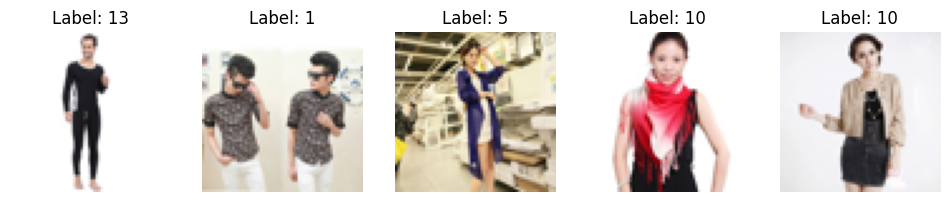

In [4]:


fig, axes = plt.subplots(1, 5, figsize=(12, 6))
for i, ax in enumerate(axes):
    ax.imshow(X_test[i].astype('uint8'))
    ax.set_title(f"Label: {y_test[i]}")
    ax.axis("off")
plt.show()


In [5]:
import numpy as np
unique, counts = np.unique(y_test, return_counts=True)
print(dict(zip(unique, counts))) 


{0: 845, 1: 636, 2: 527, 3: 1171, 4: 918, 5: 824, 6: 558, 7: 297, 8: 1017, 9: 727, 10: 523, 11: 686, 12: 946, 13: 851}


In [ ]:

X_test = data["arr_0"]  
y_test = data["arr_1"]  

X_test = np.array(X_test, dtype=np.float32) 

X_test_resized = np.array([tf.image.resize(img, (224, 224)).numpy() for img in X_test])

X_test_resized = preprocess_input(X_test_resized)  

resnet = ResNet50(weights="imagenet", include_top=False, pooling="avg", input_shape=(224, 224, 3))
X_features = resnet.predict(X_test_resized) 

clf = RandomForestClassifier(n_estimators=100, random_state=42)
cl = CleanLearning(clf)
cl.fit(X_features, np.array(y_test))  

label_issues = cl.get_label_issues()
print(f"Detected {label_issues.sum()} label issues out of {len(y_test)} samples.")

label_issues = np.array(label_issues, dtype=bool)

# 6️⃣ Filter Noisy Labels
X_clean = X_features[~label_issues]
y_clean = np.array(y_test)[~label_issues] 


clf.fit(X_clean, y_clean)
print("Model retrained on cleaned dataset.")

151/329 ━━━━━━━━━━━━━━━━━━━━ 1:51 627ms/step

In [ ]:

label_issues = label_issues[:, 0]  


label_issues = np.array(label_issues, dtype=bool)  

print(f"X_features shape: {X_features.shape}") 
print(f"label_issues shape: {label_issues.shape}")  

X_clean = X_features[~label_issues]
y_clean = np.array(y_test)[~label_issues]


X_features shape: (10526, 2048)
label_issues shape: (10526,)


In [ ]:

y_test = np.array(y_test)


X_clean = X_features[~label_issues] 
y_clean = y_test[~label_issues]  

# Check the new shapes
print(f"X_clean shape: {X_clean.shape}")  
print(f"y_clean shape: {y_clean.shape}") 


X_clean shape: (7231, 2048)
y_clean shape: (7231,)


In [ ]:
clf.fit(X_clean, y_clean)
print("Model retrained on cleaned dataset.")

Model retrained on cleaned dataset.


In [ ]:

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_clean, y_clean)  # Retrain on cleaned data


RandomForestClassifier(random_state=42)

In [ ]:
y_pred_clean = clf.predict(X_clean)
accuracy = accuracy_score(y_clean, y_pred_clean)
print(f"Accuracy after cleaning: {accuracy:.4f}")


Accuracy after cleaning: 1.0000


In [ ]:
X_test_features = resnet.predict(X_test)  
y_pred_test = clf.predict(X_test_features)  
test_acc = accuracy_score(y_test, y_pred_test)
print(f"Test Accuracy: {test_acc:.4f}")


329/329 [==============================] - 25s 73ms/step
Test Accuracy: 0.1385


In [ ]:

cv_scores = cross_val_score(clf, X_features, y_test, cv=5)
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean():.4f}")


Cross-validation scores: [0.46391263 0.45510689 0.46508314 0.44133017 0.45130641]
Mean cross-validation score: 0.4553


In [ ]:
from sklearn.svm import SVC
svm_model = SVC(kernel='linear', class_weight='balanced')
svm_model.fit(X_features, y_test)
svm_accuracy = svm_model.score(X_features, y_test)
print(f"SVM Accuracy: {svm_accuracy:.4f}")


SVM Accuracy: 0.9998


In [ ]:
from sklearn.model_selection import cross_val_score
cross_val_accuracy = cross_val_score(svm_model, X_features, y_test, cv=5)
print(f"Cross-validation accuracy: {cross_val_accuracy.mean():.4f}")


Cross-validation accuracy: 0.5194


In [ ]:
svm_model = SVC(C=10, kernel='rbf')


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform


param_dist = {
    "C": uniform(0.1, 100), 
    "gamma": uniform(0.001, 1),
    "kernel": ["rbf", "poly", "sigmoid"],  
    "degree": [2, 3, 4]  
}


svm = SVC()
random_search = RandomizedSearchCV(svm, param_distributions=param_dist, 
                                   n_iter=20, cv=5, verbose=2, n_jobs=-1, random_state=42)
random_search.fit(X_features, y_test)


print(f"Best Hyperparameters: {random_search.best_params_}")


best_svm = random_search.best_estimator_
cross_val_accuracy = cross_val_score(best_svm, X_features, y_test, cv=5)
print(f"Optimized cross-validation accuracy: {cross_val_accuracy.mean():.4f}")


Fitting 5 folds for each of 20 candidates, totalling 100 fits
